In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

from main import load_and_prepare_sessions
import numpy as np
import matplotlib.pyplot as plt

import config

sessions = load_and_prepare_sessions("../../../trial_Gq-DREADD_CPT", load_from_pickle=True, remove_bad_signal_sessions=True)

In [6]:
def update_genotypes(sessions, mice_gen_dict):
    """
    Updates the genotypes for a list of sessions based on the provided genotype mapping.
    Prints whether the genotypes are valid ('TH-Cre', 'Wildtype') 
    and the number of genotype changes made.

    Parameters:
    - sessions: A list of session objects to process.
    - mice_gen_dict: A dictionary mapping mouse IDs to new genotypes.
    """
    geno_mapping = {
        "Cre": "TH-Cre",
        "WT": "Wildtype"
    }
    # Map mice_gen_dict to use TH-Cre and Wildtype
    mapped_genotypes = {k: geno_mapping[v] for k, v in mice_gen_dict.items()}
    
    # Initialize counters and trackers
    valid_genotypes = {'TH-Cre', 'Wildtype'}
    all_genotypes = set()
    genotype_changes = 0

    for session in sessions:
        original_genotype = session.genotype
        int_id = int(session.mouse_id)
        
        if int_id in mapped_genotypes:
            session.genotype = mapped_genotypes[int_id]
            # Count changes if the genotype was updated
            if session.genotype != original_genotype:
                genotype_changes += 1
        
        all_genotypes.add(session.genotype)
    
    # Print results
    if all_genotypes.issubset(valid_genotypes):
        print(f"Valid genotypes found: {all_genotypes}")
    else:
        print(f"Invalid genotypes found: {all_genotypes}")
    
    print(f"Genotype changes made: {genotype_changes}")

In [7]:
mice_gen_dict = {
    69: "Cre",
    71: "WT",
    73: "Cre",
    75: "WT",
    77: "Cre",
    79: "WT",
    85: "WT",
    87: "WT",
    135: "WT",
    137: "WT",
    139: "Cre",
    133: "WT",
    127: "WT",
    125: "WT",
    129: "Cre",
    131: "WT",
    143: "Cre",
    145: "WT",
    147: "WT",
    157: "Cre",
    159: "Cre",
    161: "WT",
    171: "Cre",
    173: "Cre"
}

In [8]:
update_genotypes(sessions, mice_gen_dict)

Valid genotypes found: {'Wildtype', 'TH-Cre'}
Genotype changes made: 2


In [9]:
from analysis import performance_funcs

In [10]:
def running_performance_all(session, window_time, tau=100):
    """
    Computes running performance metrics over a sliding window,
    using exponentially weighted event counts so that newer events
    influence the metric more than older ones.

    Parameters:
    - session: The session object containing event data.
    - window_time: The window duration (in seconds) over which to compute metrics.
    - tau: Time constant (in seconds) for exponential decay. Smaller tau gives faster decay.

    Returns:
    - event_times: Numpy array of event times within the analysis window.
    - metrics: A dictionary where keys are metric names and values are lists of
               the computed performance values at each event.
    """
    # Filter out unwanted events
    raw_df = session.dfs.data['raw']
    filtered_df = raw_df.loc[session.events_of_interest_df["index"]]
    filtered_df = filtered_df[~filtered_df['Item_Name'].isin(['Display Image'])]
    
    event_times = filtered_df['SecFromZero_FP3002'].values
    event_names = filtered_df['Item_Name'].values
    
    # Define analysis window: from blank image to 30 minutes later
    blank_image_time = raw_df.iloc[session.cpt]['SecFromZero_FP3002']
    start_time = blank_image_time
    end_time = blank_image_time + 30 * 60  # 30 minutes
    
    start_idx = np.searchsorted(event_times, start_time, side='left')
    end_idx = np.searchsorted(event_times, end_time, side='right')
    
    event_times = event_times[start_idx:end_idx]
    event_names = event_names[start_idx:end_idx]
    
    # Combine times and names into a list of events.
    events = list(zip(event_times, event_names))
    
    # Define containers for all metrics.
    metrics = {
        'd_prime': [],
        'c_score': [],
        'participation': [],
        'total_hits': [],
        'total_mistakes': [],
        'hit_rate': [],
        'false_alarm_rate': []
    }
    
    # The performance functions expect event counts with keys as defined below.
    required_keys = ['hit', 'miss', 'mistake', 'cor_reject']
    
    # def get_window_counts(window_events, current_time, tau):
    #     """
    #     Compute weighted counts for the events in the window.
    #     Newer events (closer to current_time) receive higher weights.
    #     Weight is computed as: exp(-(current_time - event_time) / tau)
    #     """
    #     weighted_counts = {key: 0.0 for key in required_keys}
    #     for event_time, event_name in window_events:
    #         # Compute the age of the event relative to the current time
    #         dt = current_time - event_time
    #         # Exponential decay weighting; adjust tau to change decay rate.
    #         weight = np.exp(-dt / tau)
    #         event_lower = event_name.lower()
    #         if event_lower in weighted_counts:
    #             weighted_counts[event_lower] += weight
    #     return weighted_counts
    
    def get_window_counts(window_events):
        """
        Compute unweighted counts for the events in the window.
        Each event in the window contributes 1.
        """
        return {key: sum(1 for _, ev in window_events if ev.lower() == key)
            for key in required_keys}

    
    # Use a two-pointer sliding window for efficiency.
    left = 0
    for right in range(len(events)):
        current_time = events[right][0]
        # Advance left pointer to maintain window: [current_time - window_time, current_time]
        while left < right and events[left][0] < current_time - window_time:
            left += 1
        window_events = events[left:right+1]
        # counts = get_window_counts(window_events, current_time, tau)
        counts = get_window_counts(window_events)
        
        # Calculate metrics using the provided functions (assumed imported via performance_funcs)
        dp = performance_funcs.d_prime(counts)
        cs = performance_funcs.c_score(counts)
        part = performance_funcs.participation(counts)
        th = performance_funcs.total_hits(counts)
        tm = performance_funcs.total_mistakes(counts)
        hr = performance_funcs.hit_rate(counts)
        far = performance_funcs.false_alarm_rate(counts)
        
        # If a metric returns None, substitute with -1.0 (or any appropriate placeholder)
        metrics['d_prime'].append(dp if dp is not None else -1.0)
        metrics['c_score'].append(cs if cs is not None else -1.0)
        metrics['participation'].append(part)
        metrics['total_hits'].append(th)
        metrics['total_mistakes'].append(tm)
        metrics['hit_rate'].append(hr)
        metrics['false_alarm_rate'].append(far)
    
    return event_times, metrics


In [11]:
from scipy.interpolate import interp1d
from scipy import stats

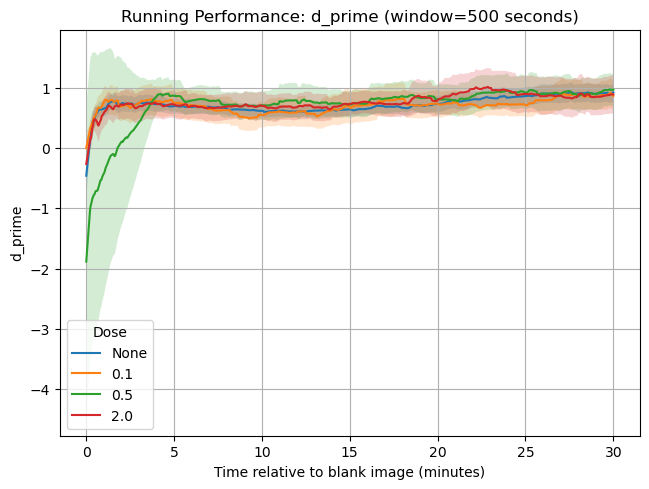

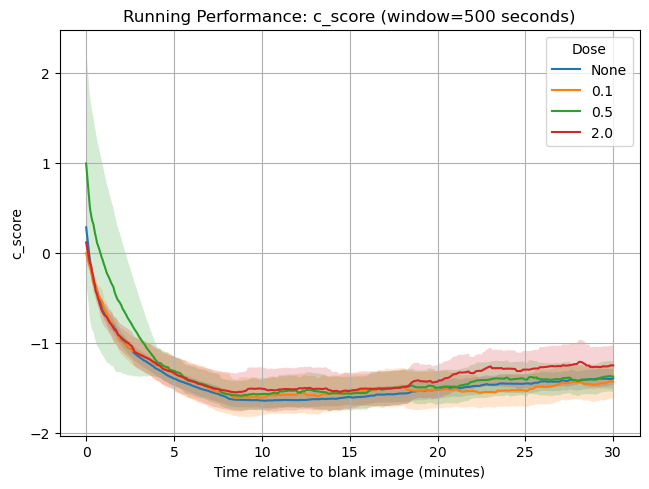

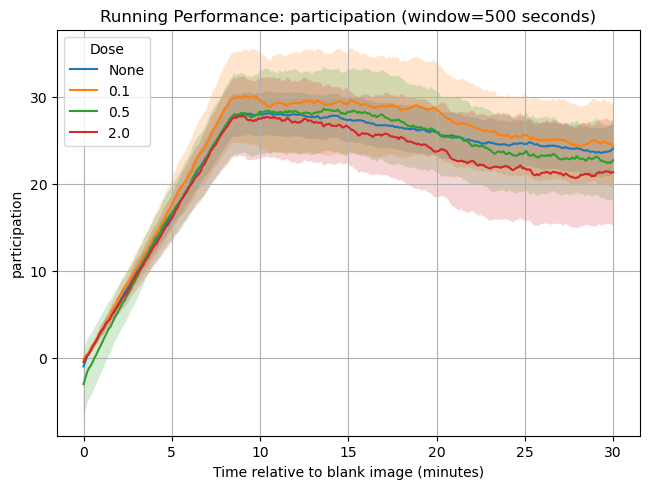

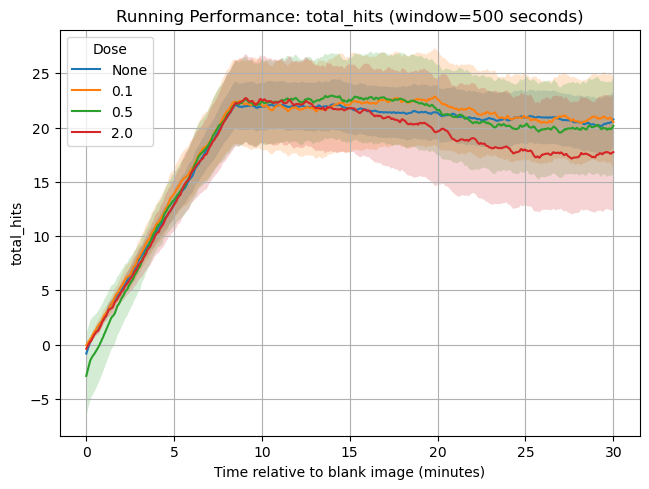

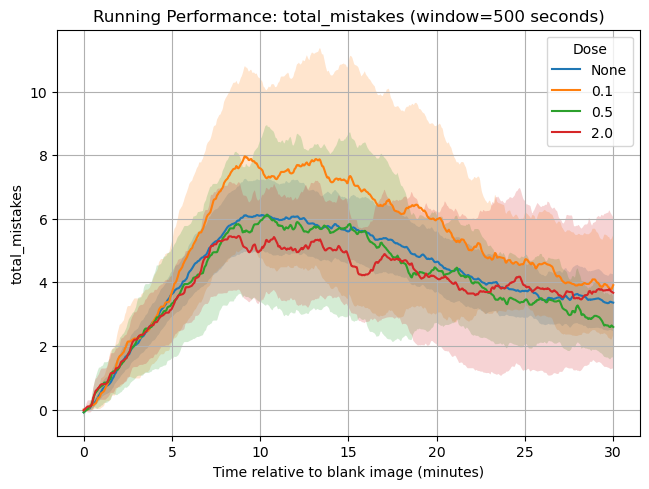

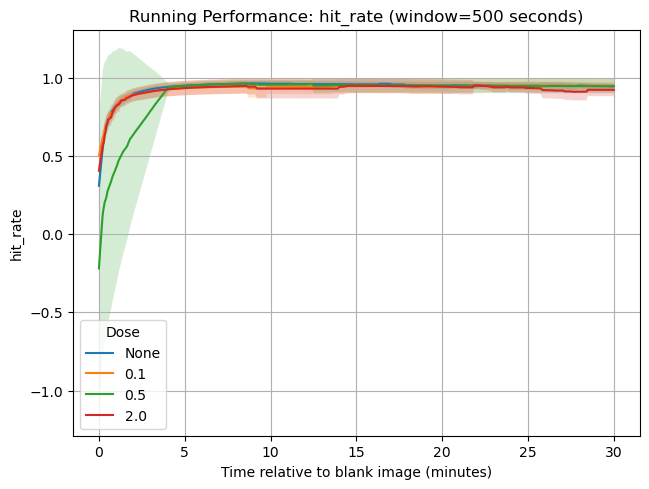

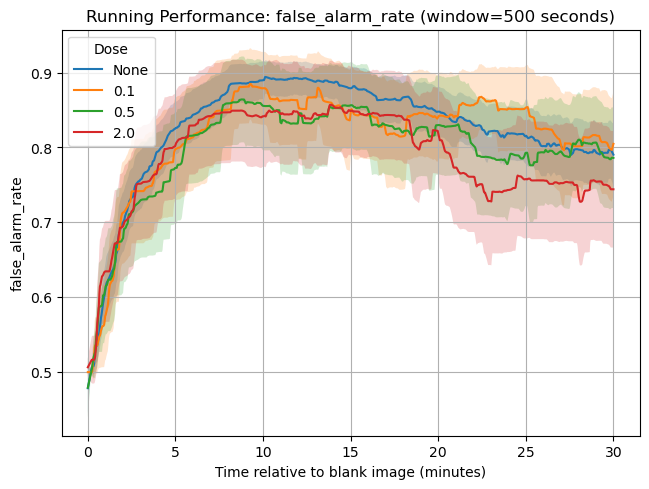

In [12]:
# Define common time grid (0 to 30 minutes) and sliding window duration
window_time = 500  # in seconds
time_start = 0  
time_end = 30 * 60  # 30 minutes in seconds
common_time_grid = np.linspace(time_start, time_end, 1000)

# Define the dose conditions and the metric names to plot.
dose_conditions = [None, '0.1', '0.5', '2.0']
metric_keys = ['d_prime', 'c_score', 'participation', 'total_hits', 'total_mistakes', 'hit_rate', 'false_alarm_rate']

# For each performance metric, create a separate plot.
for metric_name in metric_keys:
    plt.figure()  # New figure for each metric
    for dose in dose_conditions:
        interp_metric_list = []
        sessions_with_data = 0

        # Loop through sessions and filter by dose and genotype.
        for session in sessions:
            if session.genotype != 'Wildtype':
                continue
            curr_dose = session.drug_info['dose']
            if curr_dose != dose:
                continue

            try:
                event_times, sess_metrics = running_performance_all(session, window_time)
            except Exception as e:
                print(f"Skipping session due to error: {e}")
                continue

            if event_times is None or len(event_times) <= 1:
                continue

            # Get relative times based on blank image time
            blank_image_time = session.dfs.data['raw'].iloc[session.cpt]['SecFromZero_FP3002']
            relative_times = event_times - blank_image_time

            # Get the metric values for the current metric
            metric_values = sess_metrics[metric_name]

            # Interpolate onto the common time grid
            try:
                interp_func = interp1d(relative_times, metric_values, kind='linear', fill_value="extrapolate")
                interp_values = interp_func(common_time_grid)
                interp_metric_list.append(interp_values)
                sessions_with_data += 1
            except Exception as e:
                print(f"Skipping session due to interpolation error: {e}")
                continue

        if sessions_with_data == 0:
            print(f"No valid sessions for dose {dose} on metric {metric_name}.")
            continue

        # Convert to a NumPy array and compute the mean, SEM, and 95% CI.
        interp_metric_array = np.array(interp_metric_list)
        mean_metric = np.mean(interp_metric_array, axis=0)
        sem_metric = np.std(interp_metric_array, axis=0) / np.sqrt(sessions_with_data)
        ci_metric = 1.96 * sem_metric  # 95% confidence interval

        # Plot mean and fill the area for the CI (convert time to minutes)
        plt.plot(common_time_grid / 60, mean_metric, label=f"{dose}")
        plt.fill_between(common_time_grid / 60, mean_metric - ci_metric, mean_metric + ci_metric, alpha=0.2)

    plt.title(f"Running Performance: {metric_name} (window={window_time} seconds)")
    plt.grid()
    plt.tight_layout()
    plt.xlabel("Time relative to blank image (minutes)")
    plt.ylabel(metric_name)
    plt.legend(title="Dose")

    # Define filenames based on the metric name.
    png_filename = f"Running_Performance_{metric_name}_wt.png"
    pdf_filename = f"Running_Performance_{metric_name}_wt.pdf"

    # Save the figure in both formats.
    plt.savefig(png_filename, format='png', dpi=300)
    plt.savefig(pdf_filename, format='pdf')

    # Then display the plot in your notebook.
    plt.show()
